# 📊 Preprocessing Danych - Moodify

Ten notatnik przygotowuje dane do trenowania modeli:
- **Dane tekstowe** - czyszczenie, mapowanie emocji
- **Dane obrazowe** - skanowanie, organizacja, balansowanie

Bazuje na analizie z `moodify_datasets_analysis.ipynb`

## 1. Instalacja i import bibliotek

In [57]:
!pip install datasets kagglehub pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [58]:
from datasets import load_dataset
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import os
import glob

print("✅ Biblioteki załadowane!")

✅ Biblioteki załadowane!


## 2. Pobranie danych

In [59]:
print("Pobieranie AffectNet...")
affectnet_path = kagglehub.dataset_download("mstjebashazida/affectnet")
print(f"✅ AffectNet: {affectnet_path}")

print("\nPobieranie Emotion Dataset...")
emotion_dataset = load_dataset("dair-ai/emotion")
print("✅ Emotion Dataset pobrany!")

Pobieranie AffectNet...
✅ AffectNet: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1

Pobieranie Emotion Dataset...
✅ AffectNet: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1

Pobieranie Emotion Dataset...
✅ Emotion Dataset pobrany!
✅ Emotion Dataset pobrany!


## 3. Mapowanie emocji

Definiujemy wspólne kategorie dla obu zbiorów.
**Kluczowe:** Love + Joy → Szczęście

In [ ]:
text_emotion_map = {
    0: 'Smutek',
    1: 'Szczęście',
    2: 'Szczęście',  # Love → Szczęście
    3: 'Złość',
    4: 'Strach',
    5: 'Zaskoczenie'
}

image_emotion_map = {
    'happy': 'Szczęście',
    'sad': 'Smutek',
    'anger': 'Złość',
    'fear': 'Strach',
    'surprise': 'Zaskoczenie'
}

emotion_classes = ['Szczęście', 'Smutek', 'Złość', 'Strach', 'Zaskoczenie']

print(f"Wspólne emocje: {emotion_classes}")

Wspólne emocje: ['Szczęście', 'Smutek', 'Złość', 'Strach', 'Zaskoczenie']
+ Neutralny (tylko dla obrazów)


---
# PREPROCESSING DANYCH TEKSTOWYCH

## 4. Przygotowanie danych tekstowych

Mapujemy emocje i tworzymy DataFrame z tekstami.

In [61]:
def prepare_text_df(dataset, split='train'):
    texts = dataset[split]['text']
    labels = [text_emotion_map[label] for label in dataset[split]['label']]
    
    return pd.DataFrame({
        'text': texts,
        'emotion': labels
    })

train_text_df = prepare_text_df(emotion_dataset, 'train')
val_text_df = prepare_text_df(emotion_dataset, 'validation')
test_text_df = prepare_text_df(emotion_dataset, 'test')

print("✅ DataFrames utworzone")
print(f"\nTrain: {len(train_text_df)} przykładów")
print(f"Validation: {len(val_text_df)} przykładów")
print(f"Test: {len(test_text_df)} przykładów")

✅ DataFrames utworzone

Train: 16000 przykładów
Validation: 2000 przykładów
Test: 2000 przykładów


## 5. Zapisanie danych tekstowych

Zapisujemy przetworzone dane do plików CSV.

In [62]:
data_dir = Path('processed_data')
data_dir.mkdir(exist_ok=True)

train_text_df.to_csv(data_dir / 'train_text.csv', index=False)
val_text_df.to_csv(data_dir / 'val_text.csv', index=False)
test_text_df.to_csv(data_dir / 'test_text.csv', index=False)

print("✅ Dane tekstowe zapisane w 'processed_data/'")
print("   - train_text.csv")
print("   - val_text.csv")
print("   - test_text.csv")

✅ Dane tekstowe zapisane w 'processed_data/'
   - train_text.csv
   - val_text.csv
   - test_text.csv


---
# PREPROCESSING DANYCH OBRAZOWYCH

## 6. Skanowanie folderów z obrazami

Skanujemy foldery AffectNet i zbieramy ścieżki do wszystkich obrazów.

In [63]:
def scan_images(base_path, emotion_map):
    image_list = []
    
    for folder_name, emotion_label in emotion_map.items():
        pattern = os.path.join(base_path, '**', folder_name, '*.jpg')
        images = glob.glob(pattern, recursive=True)
        
        for img_path in images:
            image_list.append({
                'path': img_path,
                'emotion': emotion_label
            })
        
        print(f"{folder_name}: {len(images)} obrazów")
    
    return pd.DataFrame(image_list)

print("Skanowanie obrazów AffectNet...\n")
image_df = scan_images(affectnet_path, image_emotion_map)

print(f"\n✅ Znaleziono {len(image_df)} obrazów")

Skanowanie obrazów AffectNet...

happy: 45 obrazów
sad: 4675 obrazów
anger: 3218 obrazów
fear: 3176 obrazów
surprise: 3465 obrazów
anger: 3218 obrazów
fear: 3176 obrazów
surprise: 3465 obrazów
neutral: 128 obrazów

✅ Znaleziono 14707 obrazów
neutral: 128 obrazów

✅ Znaleziono 14707 obrazów


## 7. Podział danych obrazowych

Dzielimy dane na train/val/test (70/15/15) ze stratyfikacją.

In [64]:
from sklearn.model_selection import train_test_split

# Podział na train/val/test (70/15/15)
train_img, temp_img = train_test_split(
    image_df, 
    test_size=0.3, 
    random_state=42, 
    stratify=image_df['emotion']
)

val_img, test_img = train_test_split(
    temp_img, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_img['emotion']
)

print(f"✅ Podział danych obrazowych:")
print(f"Train:      {len(train_img)} obrazów")
print(f"Validation: {len(val_img)} obrazów")
print(f"Test:       {len(test_img)} obrazów")

print(f"\nRozkład w zbiorze treningowym:")
print(train_img['emotion'].value_counts())

✅ Podział danych obrazowych:
Train:      10294 obrazów
Validation: 2206 obrazów
Test:       2207 obrazów

Rozkład w zbiorze treningowym:
emotion
Smutek         3272
Zaskoczenie    2425
Złość          2252
Strach         2223
Neutralny        90
Szczęście        32
Name: count, dtype: int64


## 8. Zapisanie danych obrazowych

Zapisujemy przetworzone dane obrazowe do plików CSV.

In [65]:
train_img.to_csv(data_dir / 'train_images.csv', index=False)
val_img.to_csv(data_dir / 'val_images.csv', index=False)
test_img.to_csv(data_dir / 'test_images.csv', index=False)

print("✅ Dane obrazowe zapisane w 'processed_data/'")
print("   - train_images.csv")
print("   - val_images.csv")
print("   - test_images.csv")

✅ Dane obrazowe zapisane w 'processed_data/'
   - train_images.csv
   - val_images.csv
   - test_images.csv


---
# PODSUMOWANIE

## 9. Statystyki finalne

In [ ]:
print("="*60)
print("PODSUMOWANIE PREPROCESSINGU")
print("="*60)

print("\n📝 DANE TEKSTOWE:")
print(f"  Train:      {len(train_text_df):>6} przykładów")
print(f"  Validation: {len(val_text_df):>6} przykładów")
print(f"  Test:       {len(test_text_df):>6} przykładów")
print(f"  Emocje:     {len(emotion_classes)} klas")

print("\n🖼️  DANE OBRAZOWE:")
print(f"  Train:      {len(train_img):>6} obrazów")
print(f"  Validation: {len(val_img):>6} obrazów")
print(f"  Test:       {len(test_img):>6} obrazów")
print(f"  Emocje:     {len(image_emotion_map)} klas")

print("\n💾 ZAPISANE PLIKI:")
print("  processed_data/")
print("    ├── train_text.csv")
print("    ├── val_text.csv")
print("    ├── test_text.csv")
print("    ├── train_images.csv")
print("    ├── val_images.csv")
print("    └── test_images.csv")

print("\n✅ Preprocessing zakończony!")
print("   Dane gotowe do trenowania modeli.")

PODSUMOWANIE PREPROCESSINGU

📝 DANE TEKSTOWE:
  Train:       16000 przykładów
  Validation:   2000 przykładów
  Test:         2000 przykładów
  Emocje:     5 klas

🖼️  DANE OBRAZOWE:
  Train:       10294 obrazów
  Validation:   2206 obrazów
  Test:         2207 obrazów
  Emocje:     6 klas (+ Neutralny)

💾 ZAPISANE PLIKI:
  processed_data/
    ├── train_text.csv
    ├── val_text.csv
    ├── test_text.csv
    ├── train_images.csv
    ├── val_images.csv
    └── test_images.csv

✅ Preprocessing zakończony!
   Dane gotowe do trenowania modeli.


## 10. Porównanie zbiorów

Wizualizacja rozkładu emocji w zbiorach treningowych.

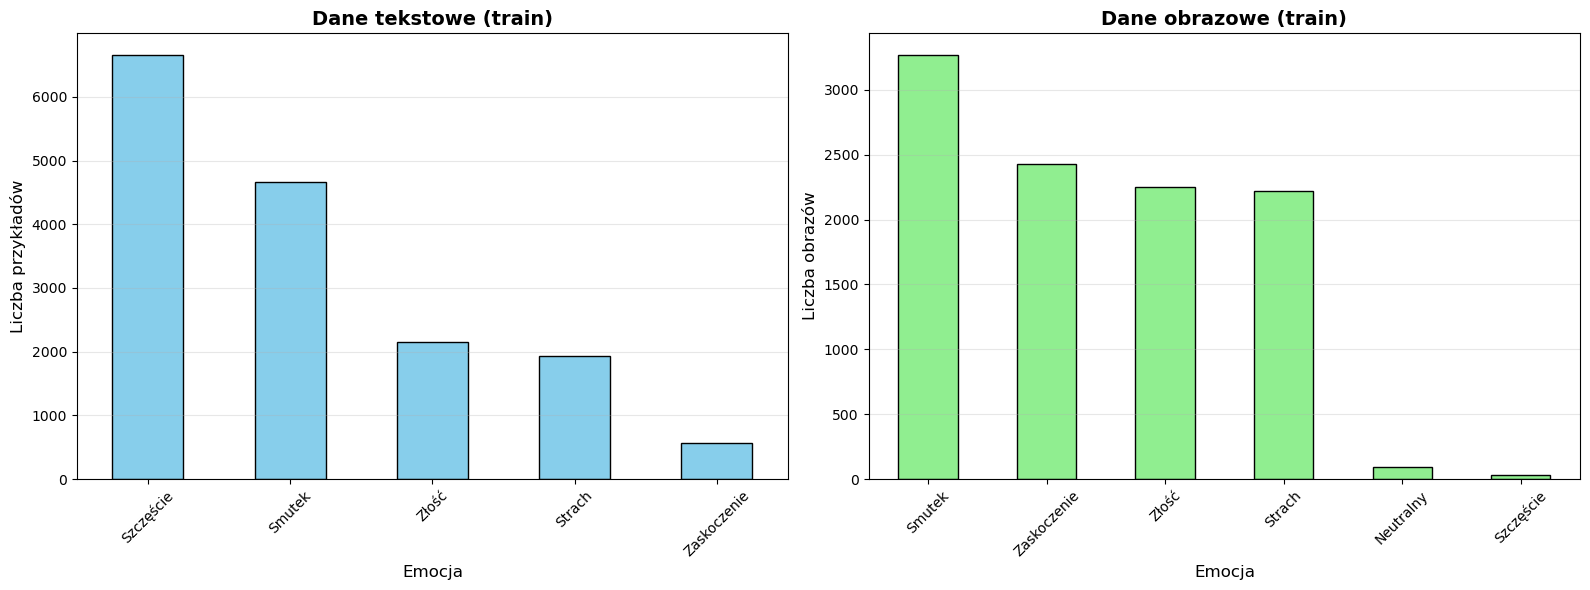

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

train_text_df['emotion'].value_counts().plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Dane tekstowe (train)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emocja', fontsize=12)
ax1.set_ylabel('Liczba przykładów', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

train_img['emotion'].value_counts().plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='black')
ax2.set_title('Dane obrazowe (train)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Emocja', fontsize=12)
ax2.set_ylabel('Liczba obrazów', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()